# Numerical Methods I

# Lecture 4: Roots of Equations

## Learning objectives:

* Identify nonlinear equations
* Solve these equations using the `scipy.optimize` functions `bisect` and `newton` 
* Explain the algorithms that underlie the Bisection, Newton and Secant method
* Explain why these methods are considered *iterative* and *approximative* and how this relates to *tolerances*
* Explain three types of *convergence* errors

## Contents
## I.      Linear Equations and Nonlinearity
## II.     Picard's method of successive approximations (or fixed point iteration)
## III.    Roots of Equations
## IV.    Subintervals and Initial Guess
## V.     Root Bracketing
## VI.    Bisection Method
## VII.   Newton Method
## VIII.  Quasi Newton Method
## IX.    Secant Method
## X.     Potential Convergence Issues


In [9]:
# some imports we will make at the start of every notebook
# later notebooks may add to this with specific SciPy modules

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# scipy's optimization
import scipy.optimize as sop

# I.   Linear Equations and Non linearity

A **system is said to be linear** if it can be represented by a **linear function** (*i.e.* a straight line in 1D):


$$ f(x) := a + kx, $$


where $f(x)$ is a quantity of interest that depends on some variable $x$, which can be quantified through measurements or observations. 

For example, if you put the money in your bank which gives **simple** interest based as a percentage of money in your 1st year, and well, you kind of forgot about this money in your bank. Years later, you rediscover the money in the bank, but your forgetfullness prevents you from remembering the details of the bank contract. However, by sifting through the bank letters in your past years, we obtain some measurement and observation about the growth of your money in the bank, and using these measurements and observations, you find the amount of money you have now in the bank, i.e. the quantity of money you currently have in the bank, which depend on some variable, i.e. the initial amount of money you put in the bank. 

Then you discover taxes and inflation, and you realize that your money depreciated through its years in the bank. Luckily, your currency of choice is not the German Marks in the 1920s Weimar Republic that might have contributed to well certain developments in the future.

To a linear system we can associate a **linear equation**, where we basically set the function to be equal to something, hence the word **equation**, which can be written in the form:


$$ f(x) = 0 \;\;\;\; \text{where} \;\;\;\; f(x) := a + kx. $$


We've set the *function* equal to something (here we chose zero) to obtain an *equation*.

[Our aim will be to find a solution $x$ to this equation. Note that for linear problems this is trivial if the problem is scalar valued, meaning that solving the above linear equation should be not be a problem for any of you. In the following lectures we will consider linear systems for vectors - i.e. matrix systems, where instead of $x$ we have a matrix, and instead of $f(x)$ we have another matrix. $a and b$ could also be matrices too! You should have done these in your mathematics modules. In the rest of this lecture, we will stick to scalars, but we will deal with equations that are non linear, since scalar linear equation shown above should be easily solvable for all of you!]

## Examples of nonlinearity

Note that the majority of real world systems cannot be expressed in such simple (linear) terms. 

[Note also that discretisations of nonlinear ODEs or PDEs (e.g. being nonlinear in order to accurately represent the nonlinear real world) results in nonlinear discrete systems for which we need to make use of techniques such as those introduced in this lecture. Discretization is the process of transferring continuous functions, models, variables, and equations into discrete counterparts. Discretizing ODEs or PDEs often mean we concenrn ourselves with a limited range for the ODEs and the PDEs, where we are actually interested. For example, ODEs and PDEs can be used to describe fluid motion, and a key parameter in the motion of material in Earth's mantle (Earth's mantle can be considered, on the geological time scale of things, to be a fluid with no strength - Dr. Rebecca Bell) is temperature (Geodynamics 2nd edition - Turcotte & Schubert). However, we know that the Earth's mantle could only possibly be within a certain temperature range, i.e. we are not expecting the mantle to be close to absolute zero, or to be hotter than the Sun, so we limit ourselves to analyzing a limited range of temperatures for our PDEs and ODEs. So if your solution to ODE or PDE somehow ends up telling you that the interior of the Earth is hotter than the Sun in your simulations, you might want to double check why Earth is not undergoing nuclear fusion.]

They are then called nonlinear systems, and equations representing them contain terms like:


-  $ x^2,\; x^3,\ldots\;\;\;$ e.g. higher ($>1$) order powers that would appear in polynomials.


- $ \sqrt{x},\; x^{1/3}, x^{\pi},\ldots \;\;\; $ e.g. roots, radicals and other non-integer polynomials.


- $\tan(x),\; \sin(x), \; \log(x),\; \text{erf}(x), \ldots \;\;\; $ e.g. trigonometric and other [*special functions*](https://en.wikipedia.org/wiki/Special_functions).


You should be familiar, for example, with quadratic equations $f(x) := a x^2 + bx + c = 0$, for which there exist the well known analytic solutions:

$$
x^*_{1,2} := \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}\,.
$$

The solutions $\,x^*_{1,2}\,$ are commonly referred to as the **roots** of the equation - this means that $\,f(x^*_{1}) = f(x^*_{2}) =0$.

## An example nonlinear equation

An example of a nonlinear problem without trivial solution is:

$$ x = \tan(x). $$

There is no exact analytic solution to this equation, so we have to devise methods to find approximate solutions of this equation.

That is, we are looking for  $x_{\text{approx}}$ such that 

$$x _{\text{approx}} \approx \tan(x_{\text{approx}}), $$ 

to a set *tolerance* (or *precision*). 

Note that we can of course equivalently look to solve the problem 

$$ f(x) \approx 0 \;\;\;\;\text{where}\;\;\;\; f(x):= x - \tan(x), $$  

[or of course equivalently we could instead choose to define $\,f(x):= \tan(x) - x$].

We will often do this (move all terms of our equation to one side and set equal to zero) to make our presentation of the theory below, as well as our implementation of solvers, generic. In this context a solution to the problem $f(x)=0$ is called a **root**.

Basically, moving everything to the one side, and letting the other side be 0 make you, the programmer, and maybe the computer's life slightly easier, so we often do this when wanting to solve equations. 


Q. Why is this equation nonlinear ? How many roots does this equation have ?


We will see a plot of this problem in a couple of cells.

# II.    Picard's method of successive approximations (or fixed point iteration)


## Fixed points

Before moving on to problems written in the completely general form $\,f(x) = 0\,$, in this section we will consider equations that can be written as:


$$ x = g(x), $$


where $g$ is a given function.

[Of course if we're given a problem of the second type we can make it look like the first simply by defining $\,f(x) := x-g(x)\,$ or $\,f(x) = g(x)-x,\,$ as we did for the problem involving $\,\tan\,$ above]

An $x$ that satisfies this equation is sometimes called a **fixed point** of the function $g$.

It's called this since if we keep applying the function $g$ to the output, then the output never changes, i.e.


$$x = g(x) = g(g(x)) = g(g(g(x))) = \ldots $$


As an example, consider the function


$$ g(x) := x^{2}-3x+4. $$


This has the fixed point 2, since $g(2)=2$.

While the example


$$ g(x) = x+1, $$


clearly has no fixed points - every application of the function adds another one to our $x$.

If we plot the function $y = g(x)$ as a curve in $(x,y)$ space then the fixed points (if they exist) are the locations where this curve intersects with the line $y=x$.

Let's see some examples.

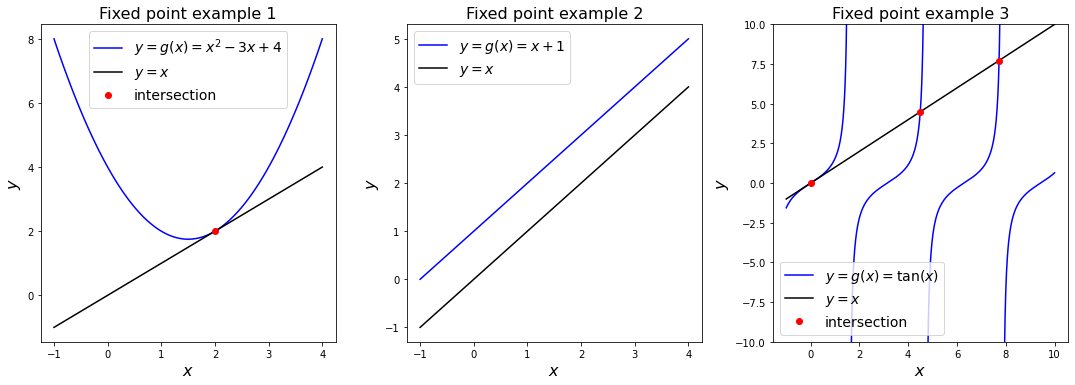

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(w_pad=4)

x = np.linspace(-1,4,100)
ax1.plot(x, x**2 - 3*x + 4, 'b', label='$y = g(x) = x^2-3x+4$')
ax1.plot(x, x, 'k', label='$y = x$')
ax1.plot(2, 2, 'ro', label='intersection')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Fixed point example 1', fontsize=16)
ax1.legend(loc='best', fontsize=14)

x = np.linspace(-1,4,100)
ax2.plot(x, x+1, 'b', label='$y = g(x)=x+1$')
ax2.plot(x, x, 'k', label='$y = x$')
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('Fixed point example 2', fontsize=16)
ax2.legend(loc='best', fontsize=14)

x = np.linspace(-1,10,1000)
y = np.tan(x)
# don't plot large values - comment out next two lines to see issue
y[y>100.] = np.inf
y[y<-100.] = -np.inf
ax3.plot(x, y, 'b', label=r'$y = g(x)=\tan(x)$')
ax3.plot(x, x, 'k', label='$y = x$')
# I know that tan(0) = 0, so I already know one of the roots 
ax3.plot(0, 0, 'ro', label='intersection')
# NB. the following values found below using bisection
ax3.plot(4.493409156799316, 4.493409156799316, 'ro')
ax3.plot(7.725251197814941, 7.725251197814941, 'ro')
ax3.set_ylim([-10,10])
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('Fixed point example 3', fontsize=16)
ax3.legend(loc='best', fontsize=14)

### Observations

The first example has a single unique fixed point, the second has no fixed point, and the third has infinitely many.

## Algorithm (Picard iteration)

The simplest method to find approximate fixed points/roots to this kind of equation consists in guessing $x$, plugging it into the right-hand-side $g(\cdot)$ and evaluating the function. 

The resulting new value for $x$ is then used as an updated guess. 

A sequence of $x^{(k)}$ values are thus defined via the iteration:

$$ x^{(k+1)} = g\left(x^{(k)}\right), $$

starting from some initial guess $x^{(0)}$.

This procedure can be repeated until some stopping criteria is met, e.g. when two consecutive values for $x$ differ by less than some user-defined tolerance.   

Note that here 

$$x^{(k+1)} - x^{(k)} = g\left(x^{(k)}\right) - x^{(k)}$$ 

and so the 'change in $x$' value dropping below our tolerance is equivalent to us satisfying $x=g(x)$ to that same tolerance!

This strategy is often referred to as (Picard's) method of successive approximations. 

A pseudo-code description of this solution strategy looks like

```
guess x
x_previous := x + 2*tolerance   # so that the initial evaluation in the while loop is true.
while ( abs(x - x_previous) > tolerance ) do   
    x_previous := x
    x := g(x_previous)
```

<span style="color:red"> The superscript here does not always mean raising something to a certain power as we usually mean. In mathematics, superscript is also used to note the steps of an iteration. The first step would be 0 (remember: Python index starts from 0), i.e. $x^0$ and $g(x)^0$ and the next step would be 1 i.e. $x^1$ and $g(x)^1$ </span>

Basically, Picard Iteration starts with your equation in the form of

$$x=g(x)$$

We can take an initial guess for $x$ and see what does $g(x)$ result in. Your initial guess would probably result in $x$ not equal to $g(x)$ that you found. That is not a problem, that is okay. You cannot expect to get the answer to the equation through simple guessing alone. There will be certain difference between your initial guess of $x$ and the initial $g(x)$ you found, let's call this difference $d^0$

Since we are doing iteration, and since Python index starts from $0$. Let's call the initial guess to be $x^0$ and the result you get from the initial guess to be $g(x)^0$. 

We could try to guess again, and maybe this time, our guess will be better, or maybe not. Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value, and then find a new $g(x)$.

Therefore, this time
You will use the result you have obtained from $g(x)^0$ as your next guess for $x$ and use that to obtain $g(x)^1$

$$x^1 = g(x)^0$$
$$x^1 = g(x)^1$$

Now your $x^1$ and your $g(x)^1$ are probably still not the same. And that's is still okay. We again note down the difference between $x^1$ and $g(x)^1$, and we can call this difference $d^1$

Now, there are $2$ possible outcomes. 

The outcome desired is that $d^1$ is smaller than $d^0$, i.e. $d^1<d^0$, which means that the difference between $g(x)^{sth}$ and $x^{sth}$ is decreasing. In our case here, it is that the difference between $x^0$ and $g(x)^0$ decreased when we moved forward one iteration step to find the difference between $x^1$ and $g(x)^1$. Remember, you are trying to solve for the equation that $x = g(x)$, which means that you want to find the value of $x$ so that there is no difference in between $x$ and $g(x)$. If the difference decreases, it is good. If the difference keeps decreasing, it is very good, since eventually the difference becomes so small, that $x$ and $g(x)$ becomes effectively the same. Even though you may argue that $x$ and $g(x)$ will always have a teeny tiny difference no matter how many steps you go, would you really care about that difference like on the (insert random large numebr)th decimal place, when the (the random large number from before, but minus 1) decimal place are all the same? Probably not. Your lecturers and professors always advice against like writing lots of decimals places on your test, and may even mark you down for that. You should also note that your computer hardware may not even support that many decimal places and even for the most expensive of hardware, there is a certain limit to their floating point precision.

If the difference between the $g(x)^{sth}$ and $x^{sth}$ keeps on decreasing, then you can state that $g(x)^{sth}$ and $x^{sth}$ are moving closer to one another, and you can say that $g(x)^{sth}$ and $x^{sth}$ are converging towards a certain value. When they have moved so close that they are essentially the same, then you haved solved the equation  $x = g(x)$. We note that for us to arrive at the solution to the equation, we need $g(x)^{sth}$ and $x^{sth}$ to move ever closer to one another during our iteration process. In other wrods, our iterations needs to be **Converging**. 

The outcome undesired is when it is **Diverging**. Since we know that to arrive at our solution, we need the $g(x)^{sth}$ and $x^{sth}$ are moving closer to one another, so that eventually they could be the same, and satisfy the statement that $x = g(x)$, if $g(x)^{sth}$ and $x^{sth}$ are moving away from one another, a.k.a **Diverging**, then they would be getting further away from each other with every iteration, and thus we will never arrive at $x=g(x)$

Let's see an example using $x=e^{-x}$

<span style="color:red"> The superscript here does not always mean raising something to a certain power as we usually mean. In mathematics, superscript is also used to note the steps of an iteration. The first step would be 0 (remember: Python index starts from 0), and the next step would be 1 etc. Yeah, this is kinda confusing, but maybe you'll get used to it?</span>

So Picard's iteration had the form of

$$x = g(x)$$

Since the equation we are trying to solve this $x = e^{-x}$, comparing the two, I can state that the $g(x)$ for this case is:

$$g(x)=e^{-x}$$

**Step 1:**

Let's start with an initial guess, that $x = 1$, and thus we would write that $x$ at our first step would be $1$. 

$$x^0 = 1$$

I know that $g(x) = e^{-x}$. Since $x^0 = 1$, I know that my corresponding $g(x)^0 = e^{-1} = 0.36788$ 

Since my $x^0 = 1$ and my $g(x)^0 = 0.36788$, I see that $x^0 \neq g(x)^0$. <span class ="irony">Gasp, my initial guess was wrong. How dreadful!</span>

I note down that the difference between $x^0$ and $g(x)^0$ is 0.63212, so I write that 

$$d^0 = 0.63212$$

To summarize, I have obtained the following from this Step 1:

$$x^0 = 1$$
$$g(x)^0 = 0.36788$$
$$d^0 = 0.63212$$

**Step 2:**

We could try to guess again, and maybe this time, our guess will be better, or maybe not. Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value, and then find a new $g(x)$.

From my previous step, so step 1, I have

$$x^0 = 1$$
$$g(x)^0 = 0.36788$$
$$d^0 = 0.63212$$

Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value, and then find a new $g(x)$. 

The step previous to step 2 is step 1. 

The $g(x)$ that you have found in the previous step, so step 1, is 

$$g(x)^0 = 0.36788$$.

Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value. The $x$ in the new step, so step 2, is $x^1$. The value of $g(x)$ in the previous step is $g(x)^0 = 0.36788$, thus I will write that 

$$x^1 = 0.36788$$

Picard iteration then tell me to find a new $g(x)$ using $x$ in the new step. The new step is step 2, and the $x$ in step 2 is $x^1 = 0.36788$

Thus I obtain the new $g(x)$ called $g(x)^1$ as

$$g(x)^1 = e^{-x^1} = e^{-0.36788} = 0.69220$$

Since my $x^1 = 0.36788$ and my $g(x)^1 = 0.69220$, I see that $x^1 \neq g(x)^1$. 

I note down that the difference between $x^1$ and $g(x)^1$ is 0.32432, so I write that 

$$d^1 = 0.32432$$

At this point, it is important to see whether your iteration is **converging or diverging**. It is only worthwhile, for the equation we are solving, to continue doing the iterative process if the iteration is **converging**. To see if it is converging, we compare the difference we found at **Step 1** and the difference we found at **Step 2**. 

$$d^0 = 0.63212$$
$$d^1 = 0.32432$$

I observe that the difference we found at **Step 2** is smaller than the we found at **Step 1**, i.e. $d_1 < d_0$, thus, I can say, at least from **Step 1** to **Step 2**, the difference is decreasing, so the iteration is **converging**. Converging is good. 

Concluding

$$x^1 = 0.36788$$
$$g(x)^1 = 0.69220$$
$$d^1 = 0.32432$$

**Step 3:**

This is basic doing **Step 2** all over again. You could skip this if you wish. 

From my previous step, so step 2, I have

$$x^1 = 0.36788$$
$$g(x)^1 = 0.69220$$
$$d^1 = 0.32432$$

Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value, and then find a new $g(x)$. 

The step previous to step 3 is step 2. 

The $g(x)$ that you have found in the previous step, so step 2, is 

$$g(x)^1 = 0.69220$$

Picard Iteration basically tells you to take the $g(x)$ that you have found in the previous step and replace $x$ in the new step with this value. The $x$ in the new step, so step 3, is $x^2$. The value of $g(x)$ in the previous step is $g(x)^1 = 0.69220$, thus I will write that 

$$x^2 = 0.69220$$

Picard iteration then tell me to find a new $g(x)$ using $x$ in the new step. The new step is step 3, and the $x$ in step 3 is $x^2 = 0.69220$

Thus I obtain the new $g(x)$ called $g(x)^2$ as

$$g(x)^1 = e^{-x^2} = e^{-0.69220} = 0.50047$$

Since my $x^2 = 0.69220$ and my $g(x)^2 = 0.50047$, I see that $x^2 \neq g(x)^2$. 

I note down that the difference between $x^1$ and $g(x)^1$ is 0.32432, so I write that 

$$d^2 = 0.19173$$

At this point, it is important to see whether your iteration is **converging or diverging**. It is only worthwhile, for the equation we are solving, to continue doing the iterative process if the iteration is **converging**. To see if it is converging, we compare the difference we found at **Step 2** and the difference we found at **Step 3**. 

$$d^1 = 0.32432$$
$$d^2 = 0.19173$$

I observe that the difference we found at **Step 3** is smaller than the we found at **Step 2**, i.e. $d_2 < d_1$, thus, I can say, at least from **Step 3** to **Step 2**, the difference is decreasing, so the iteration is **converging**. Converging is good. 

And so on and so forth. The cells below will show you the further steps of the iteration process. 

<span style="color:red">Note that, while we did some steps here, and we found that up until these steps, our iteration was converging, this does not neccesary mean that it will keep on converging in future steps. While for our case it does keep on converging for the next steps, it is not neccesary. Indeed, the only way you could know if it would keep on converging is through rigorous mathematical proof and you could always ask your lecturers for your mathematics modules to give you an introduction into this. However, note that, there is no universal way applicable to all iterative methods to prove that they will converge as their step number continues to increase. There has been many cases in history where the iterative method converged for the first tens of hundreds of steps, thus creating the illusion that it will keep on converging till infinity, when suddently at the thousandth term it starts diverging. Some have even weirder behaviour where it converges for a while, then diverges for another while, and cycles, regularly or irregularly in between, and possibly having a general converging pattern or a general diverging pattern, or maybe you're just seeing patterns when there are actually none. Indeed, whether something converges or diverges is still a very active area of research in mathematics, and there are sometimes some nice prizes for anyone who can provide rigorous mathematical proof that something converges or diverges. </span>


## <span style="color:blue">Exercise 4.1: </span>

Complete the implementation of the method of successive approximations below to solve $x=\mathrm{e}^{-x}$

In [11]:
def picard(f, x, atol=1.0e-6):
    """ Function implementing Picard's method.
    
    f here is the function g(.) described in the lecture and we are solving x = g(x).
    
    x is an initial guess.
    
    atol is a user-defined (absolute) error tolerance.
    """
    # record number of function evaluations so we can later compare methods
    fevals = 0
    # initialise the previous x simply so that while loop argument is initially true
    x_prev = x + 2*atol
    while abs(x - x_prev) > atol:
        x_prev = x
        
        
        # ONE LINE OF MISSING CODE HERE
        
        
        fevals += 1
        print('Current iteration solution: ',x)
    print('\nPicard used', fevals, 'function evaluations')
    return x



def g(x):
    return np.exp(-x)


print('\nSolution from Picard: ', picard(g, 0.9, atol=1.0e-7))  # 0.9 is our initial guess


# let's check our answer against a SciPy function: sop.newton.
def f(x):
    return x - np.exp(-x)

print('\nCheck this against the solution from SciPy: sop.newton(f, 0.9)=', sop.newton(f, 0.9))

# NB. if we tighten up the atol toelrance in our call to picard the answer gets closer to SciPy 
# but of course takes more iterations.

Current iteration solution:  0.9

Picard used 1 function evaluations

Solution from Picard:  0.9

Check this against the solution from SciPy: sop.newton(f, 0.9)= 0.5671432904097843


To get a better idea of what is going on here let's look at the progression of the intermediate results $\,x^{(k+1)}\,$ from $\,x^{(k+1)} = g\left(x^{(k)}\right)\,$, and plot them on top of the curve $y = \mathrm{e}^{-x}$.

NB. I include the plotting code here for completeness, but you can ignore the details if you're not interested.

x_00 = 1.00000.   g(x_00) = 0.36788.   |x_00 - g(x_00)| = 0.63212
x_01 = 0.36788.   g(x_01) = 0.69220.   |x_01 - g(x_01)| = 0.32432
x_02 = 0.69220.   g(x_02) = 0.50047.   |x_02 - g(x_02)| = 0.19173
x_03 = 0.50047.   g(x_03) = 0.60624.   |x_03 - g(x_03)| = 0.10577
x_04 = 0.60624.   g(x_04) = 0.54540.   |x_04 - g(x_04)| = 0.06085
x_05 = 0.54540.   g(x_05) = 0.57961.   |x_05 - g(x_05)| = 0.03422
x_06 = 0.57961.   g(x_06) = 0.56012.   |x_06 - g(x_06)| = 0.01950
x_07 = 0.56012.   g(x_07) = 0.57114.   |x_07 - g(x_07)| = 0.01103
x_08 = 0.57114.   g(x_08) = 0.56488.   |x_08 - g(x_08)| = 0.00626
x_09 = 0.56488.   g(x_09) = 0.56843.   |x_09 - g(x_09)| = 0.00355
x_10 = 0.56843.   g(x_10) = 0.56641.   |x_10 - g(x_10)| = 0.00201
x_11 = 0.56641.   g(x_11) = 0.56756.   |x_11 - g(x_11)| = 0.00114
x_12 = 0.56756.   g(x_12) = 0.56691.   |x_12 - g(x_12)| = 0.00065
x_13 = 0.56691.   g(x_13) = 0.56728.   |x_13 - g(x_13)| = 0.00037
x_14 = 0.56728.   g(x_14) = 0.56707.   |x_14 - g(x_14)| = 0.00021
x_15 = 0.5

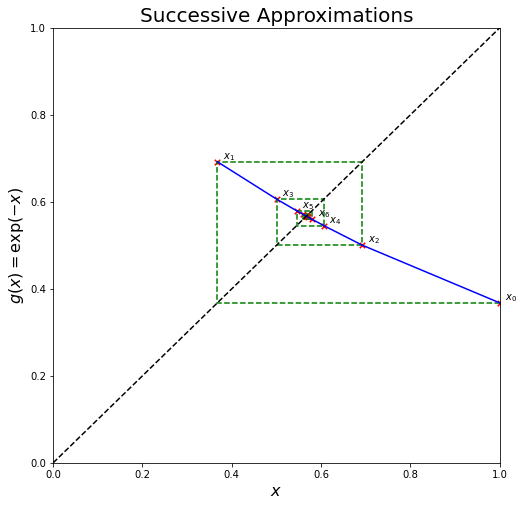

In [12]:
def plot_picard_convergence(f, x, ax, max_labels=6, atol=1.0e-4, flabel=''):
    """ Function to demonstrate/plot the Picard algorithm and its convergence
    """
    # variables to store solution iterations for plotting purposes
    xs = []
    fs = []

    # the following is identical to our iteration above, apart from storing iterations
    x_prev = x + 2*atol
    while abs(x - x_prev) > atol:
        x_prev = x
        x = f(x_prev)
        print('x_{0:0>2d} = {1:7.5f}.   g(x_{0:0>2d}) = {2:7.5f}.   |x_{0:0>2d} - g(x_{0:0>2d})| = {3:7.5f}'.
              format(len(xs), x_prev, x, abs(x_prev-x)))
        xs.append(x_prev)
        fs.append(x)  # as x = g(x_prev) at this point we can store this

    # plot the iteration results
    ax.scatter(xs, fs, marker='x', color='red', s=30)

    # plot the convergence pattern
    x_pattern = [xs[0]]
    f_pattern = [fs[0]]
    for i in range(1, len(xs)):
        x_pattern.append(xs[i])
        f_pattern.append(fs[i-1])
        x_pattern.append(xs[i])
        f_pattern.append(fs[i])
    ax.plot(x_pattern, f_pattern, 'g--')

    # plot the function over the x values considered
    idx_sort = np.argsort(xs)
    ax.plot(np.array(xs)[idx_sort], np.array(fs)[idx_sort], 'b')

    # add some labels
    # figure out a reasonable offset for labels
    dxt = (np.max(x_pattern)-np.min(x_pattern))/50.
    dyt = (np.max(f_pattern)-np.min(f_pattern))/50.
    ax.text(xs[0]+dxt, fs[0]+dyt, '$x_0$')
    # only plot a maximum of max_labels labels, so plot doesn't get too messy
    for i in range(1, min(max_labels+1, len(xs))):
        label = ''.join(['$x_{', str(i), '}$'])
        ax.text(xs[i]+dxt, fs[i]+dyt, label)

    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Successive Approximations', fontsize=20)


def g(x):
    return np.exp(-x)

# set up a figure for plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
# set an initial guess - you can try different values for x_guess
x_guess = 1.0
# call our plotting function with above choice of function g(.), use the default stopping criterion
plot_picard_convergence(g, x_guess, ax1, flabel=r'$g(x) = \exp(-x)$')

# add a y=x line without extending the axes limits
ax1.autoscale(False)
xlim = plt.gca().get_xlim()
ax1.plot(xlim, xlim, 'k--')

Recall that we introduced this so-called ["cobweb plot"](https://en.wikipedia.org/wiki/Cobweb_plot) in ACSE-2.

- We start from $x^{(0)}=1.0$ - shown as $x_0$ in the plot.


- We evaluate $g(x^{(0)}) = 0.36788...$. The red cross marked as $x_0$ is plotted at the location $(x^{(0)},g(x^{(0)}))$.


- We set our new iteration value, $x^{(1)}$, to this '$y$' value (i.e. $0.36788...$) - the lowest green dashed horizontal  line takes us from $x^{(0)}$ to this new $x^{(1)}$ - we jump horizontally to the $y=x$ line given by the black dashed line.


- We then evaluate $g(x^{(1)}) = 0.69220...$ - the left most vertical green dashed line takes us to this value on the $y$ axis where the second red cross marked with $x_1$ is plotted at the location $(x^{(1)},g(x^{(1)})$.


- We set our new $x$ value to this (0.69220), and this is indicated by the top most horizontal green dashed line taking us back to the $y=x$ black dashed line.


- Evaluate $g$ of this value giving us 0.50047, this is our next vertical line


- and so on, converging to our fixed point

This plot shows that our algorithm *converges* to the point where $x = g(x)$, which in our case is $x = \mathrm{e}^{-x}$.

For this example this is the point where both $x$ and $g(x)$ equal ~0.57. 

It should be obvious that this method is iterative in nature and that the solution can be expected to be an approximation accurate to a tolerance of $e \leq$ `atol`. 

As we said at the start of this lecture, another way to visualise this is to plot the functions $y = x$ and $y = \mathrm{e}^{-x}$ in $(x,y)$ space and find the intersection.

Text(0.5, 1.0, 'Fixed point as the intersection of two curves')

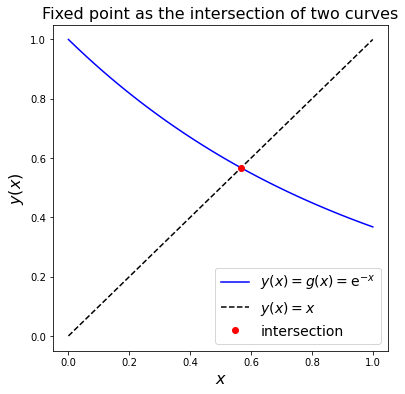

In [13]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

x = np.linspace(0, 1, 100)

ax1.plot(x, np.exp(-x), 'b', label=r'$y(x) = g(x) = \mathrm{e}^{-x}$')
ax1.plot(x, x, 'k--', label='$y(x)=x$')
# our solution from Picard above: 0.5671430835570621
ax1.plot(0.5671430835570621, 0.5671430835570621, 'ro', label='intersection')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y(x)$', fontsize=16)
ax1.set_title('Fixed point as the intersection of two curves', fontsize=16)

# III. Roots of equations

This graphical method shows the intersection point, $x = \mathrm{e}^{-x}$, also at ~0.57. 

This value is also termed a *root* of a closely related problem, as it satisfies 

$$ 0 = f(x) := x - \mathrm{e}^{-x}. $$

[So a "fixed point" can always be defined as a "root" of a related problem, but the opposite is not strictly speaking true. However, we will see below how it is possible to update the problem of finding a "root" to finding a "fixed point", and hence reapply this sort of fixed point iteration approach to this more general problem].

In this expression we rearranged $\,x = \mathrm{e}^{-x}\,$ to $\,0 = x - \mathrm{e}^{-x}\,$ and defined $\,f(x) := x - \mathrm{e}^{-x}$. 

Thus, another solution strategy is to find a value $x^*$ such that $f(x^*) = 0$, or, in our case, $x^* - \mathrm{e}^{-x^*} = 0$. 

We can of course plot a similar intersection figure for this modified problem.

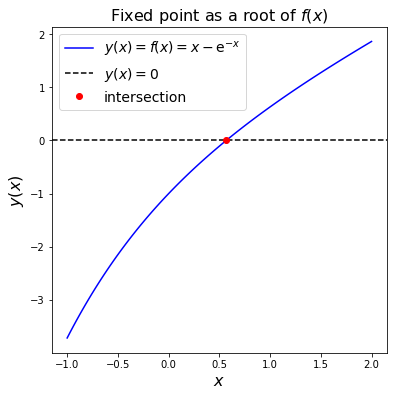

In [14]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)

x = np.linspace(-1, 2, 100)

ax1.plot(x, x-np.exp(-x), 'b', label='$y(x) = f(x) = x - \mathrm{e}^{-x}$')
# add a zero line extending across axes
xlim = ax1.get_xlim()
ax1.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')
ax1.plot(0.5671, 0., 'ro', label='intersection')
ax1.set_xlim(xlim)
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y(x)$', fontsize=16)
ax1.set_title('Fixed point as a root of $f(x)$', fontsize=16);

# IV.   Subintervals and initial guesses
    
As we have seen from the iterative method above, having a good initial guess is helpful when iterating for a solution to an equation. If you have made an initial guess that is very close to the solution, then it would take much fewer steps to get to the solution, while if you have made an initial guess that is very far from the solution, then it would take many more steps to get to the solution. 

We also should seek to improve upon our iterative methods. We will introduce you to some of the most common solution seeking iterative methods below. Many of these methods share many similarities and have certain differences. In particular, we are interested in the number of steps taken to reach the solution for each method of seeking the solution. If a solution is reached quickly, the computer can spend less time finding the solution. While this may seem trivial when we are doing scalar equations, it would become important when trying to solve equations involving large and complicated matrixes. The fewer number of steps also means there is a much smaller chance that the program will catastrophically fail when trying to reach the solution. You will know the frustration when you are running numerical simulations lasting several hours only for the computer to catastrophically fail in the middle of it, and having to run it again, when the sun is already rising from the horizon.     
    
The graph shows the root of $f(x)$ at our solution $x^* \approx 0.57$. By visual inspection, we see that $f(x)$ has a root $f(x^*) = 0$ in the interval $x^* \in (-1,1)$. 





## <span style="color:blue">Exercise 4.2:</span>


Let's consider an example:

$$2\,x + x \, \sin(x-3) = 5\;\;\;\; \text{for}\;\;\;\; x \in (-10,10).$$


By means of visual inspection (i.e. do some plotting) find a subinterval $(a,b)$ such that 


1. there exists an $x^* \in (a,b)$ such that $f(x^*) = 0$, and 


2. $f(x)$ is [monotonic](https://en.wikipedia.org/wiki/Monotonic_function).

Where we define $f$ such that the solution to the above equation is a root - i.e. move all the terms on to one side and set equal to zero. Below we make the choice to define $f$ as $f(x) = 2\,x + x \, \sin(x-3) - 5$.

In [15]:
# for this problem we can define f as 5 - (2*x + x*np.sin(x-3)), or (2*x + x*np.sin(x-3)) - 5.
# it makes no difference to the root-finding, just the plots
def f(x):
    return ..............

# plot the function over the whole interval being considered
x = np.linspace(-10,10,100)

# now plot the function over a smaller interval
x = np.linspace(..... ,..... , 100)

SyntaxError: invalid syntax (<ipython-input-15-4bd9b984d5c9>, line 4)

You should find that in $(0,5)$, i.e. an interval with upper and lower bounds $a$ = 0 and $b$ = 5, there exists a root, and also the function is monotonically increasing over this interval - we have excluded any local maxima or minima that we see do occur in the function outside this restricted interval.

[Note the caveat that in general we will assume the evaluation of $\,f$ (or $g$) is expensive and so we want to do this as few times as possible - generating a nice high resolution plot like this is not something we will be able to do in general].

We can make use of this knowledge to help us identify a good starting guess for the root.

# V.    Root bracketing

Where the root lies can be important.

By visual inspection we can identify if roots exist for a function, and narrow down the interval in which a root can be found. 

For the equation 

$$f(x) := x - \text{e}^{-x},$$ 

we have shown by plotting (above in two images, see also below, where we noted a root around $x\approx ~0.57$) that a root is bounded in $(-1,1)$, and that $f(x)$ is monotonically increasing over this interval. 

With this in mind, we can define a [*root bracketing algorithm*](https://en.wikipedia.org/wiki/Root-finding_algorithm#Bracketing_methods) that marches along $f(x)$ in increments of $\Delta x$ and identifies a new, tighter (i.e. smaller) bracket around the root by detecting a *change in sign of $f(x)$*. 

This algorithm is also referred to as *incremental search*. 

Basically, it is important to know where the root is to sovle the equation. Of course, if we would have known exactly where the root was, then there would be no need for iterative method. However, we could maybe try to narrow down the location where the root lies. 

Your seismology courses would teach you that to find the location of an earthquake, you will use multiple seismometers, and each will give a measurement of the distance from the seismometer to the earthquake location by using arrival times and P wave velocity. Each seismometer will give you a circle. Combining two seismometer narrows down the area, and three seismometers would give you the location of the earthquake. However, because earthquakes are very complex (we are not talking about massive earthquakes where an entire zone just rips apart since the earthquake center is more like a belt rather than a point for earthquakes of this scale), you will use way more than just 3 seismometers to locate your earthquake, and each additional seismometer will improve your confidence of where is the center of the earthquake. 

Similarly, we could try to narrow down the area where our root is located. You will use multiple iterations to find the location of your root, and each iteration will improve upon the previous iteration to narrow down where the root is located. We call this root bracketing, since we are trying to find the location of the root by narrowing down the area where the root could be, but also incremental search, since each iteration is based on the previous iteration, and incrementally improves our search for the root. 

For our root bracketing algorithm, we will start with a wide area, and check if there is a root located in that area. If there is a root, then we will break this area we found into smaller subintervals, and then try to find if there is root in them. If we find a root in a subinterval, then we would break this subinterval into even smaller pieces, i.e. subintervals of subinterval, and try to find a root in it. If we don't find a root in a subinterval, or subinterval of subinterval, or subinterval of subinterval of subinterval (you get the idea :)), then we just ignore it, and only work with subintervals which have root in them. 

The approach can be visualised as follows:

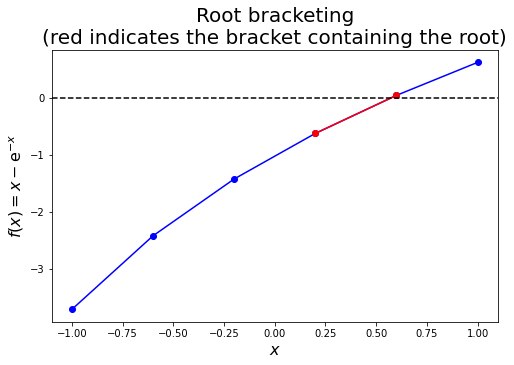

In [16]:
def plot_root_bracketing(f, a, b, dx, ax, xbounds=(-0.1, 1.4), ybounds=(-5, 6), flabel=''):
    x = np.linspace(a, b, int((b-a)/dx)+1)
    y = f(x)
    # plot the sub-intervals in blue
    ax.plot(x, y, 'bo-')
    for i in range(1, len(x)):
        if np.sign(y[i]) != np.sign(y[i-1]):
            # plot the sub-interval where the sign changes in red
            ax.plot([x[i], x[i-1]], [y[i], y[i-1]], 'ro-')
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)
    ax.set_title('Root bracketing\n' + '(red indicates the bracket containing the root)', fontsize=20)

    
def f(x):
    return x - np.exp(-x)


fig, ax1 = plt.subplots(figsize=(8,5))
    
lower_bound = -1.
upper_bound = 1.
dx = 0.4
plot_root_bracketing(f, lower_bound, upper_bound, dx, ax1, flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

## <span style="color:blue">Exercise 4.3: </span>
    
For $2x + x \mathrm{sin}(x-3) = 5$, use the subinterval $x \in(a,b)$ you found in Exercise 4.2 and complete the code below to implement a function for the root bracketing algorithm. Derive the concept from the Figure above

In [17]:
def f(x):
    return 2*x + x*np.sin(x-3) - 5


def root_bracketing(f, a, b, dx):
    """ Function to perform root bracketing on the function f(.)
    between a and b, with fixed interval size dx.
    Returns the bracket of size dx that contains the root.
    """ 
    # The sign function returns:  -1 if x < 0;  0 if x==0;  1 if x > 0.
    sign = np.sign(f(a))
    while ...
        .....
    return (a-dx, a)


a = 0.
b = 5.
dx = 0.1
# print out the output from our root_bracketing function
print('Bracket = ', root_bracketing(f, a, b, dx))

SyntaxError: invalid syntax (<ipython-input-17-bbc1b21e490b>, line 12)

# VI.    Bisection method

Once we know that a root can be found in $x \in (a,b)$, we can close in on it with an algorithm similar to root-bracketing/incremental search described above, but with a smart switch to gradually *decrease* $\Delta x$ *by a factor* of 1/2, and *change the marching direction* depending on the sign of $f(x_1)f(x_2)$, where $x_1$ and $x_2$  are the local bounds considered during the marching process.


The algorithm works as follows:


- If there is a root in the interval $[x_1, x_2]$, then $f(x_1)f(x_2) < 0$ (as $f(x_1)$ and $f(x_2)$ will be of different signs)


- In order to halve the interval, we compute $f(x_3)$, where $x_3 := (x_1 + x_2)/2$ is the midpoint of the current interval. 


- If $f(x_2)f(x_3) < 0$, then the root must be in $[x_2, x_3]$, and we record this by replacing the original bound $x_1$ by $x_3$,


- otherwise, the root must lie in $[x_1, x_3]$, in which case $x_2$ is replaced by $x_3$. 


- In either case, the new updated interval $[x_1, x_2]$ is half the size of the original interval. 


- The bisection is repeated until the interval has been reduced to some user-defined convergence tolerance.

Ok, so what you do during the bisection method is simple, and should have probably been covered in A Level Maths. 

Nevertheless, let's start with our equation, and we note that it is important that we move our equation in such a way that there is a 0 on either the left hand side or the right hand side of the equation. 

For example, if our equation was say given in the form of:

$$x = sin(x)$$

Then it is important that we change our equation to be:

$$x-sin(x) = 0$$

And then we could define a function such that:

$$f(x) = x - sin(x)$$

Since we are seeking to find $x$ when the statement $x = sin(x)$ is true, then this is equivalent to finding $x$ when $f(x) = 0$ is true. Thus we can say that by finding the $x$ when $f(x)=0$ is True, we will also find the $x$ when $x = sin(x) is True$

If we assume that our function is monotonic around when $f(x)=0$, so the function is only increasing or decreasing, then

if the function was increasing from left to right, then to the left of $f(x)=0$, we will have the function $f(value\;\; immediately\;\; left\;\; of\;\; x)<0$, and to the right, we will have function $f(value \;\; immediately\;\; right\;\; of\;\; x)>0$

if the function was decreasing from left to right, then to the left of $f(x)=0$, we will have the function $f(value\;\; immediately\;\; left\;\; of\;\; x)>0$, and to the right, we will have function $f(value \;\; immediately\;\; right\;\; of\;\; x)<0$

Below I have quickly made two graphs for two monotonic function to illustrate what I said. 

Since the left and right have opposite signs, then multiplying their values together would give a negative number, since positive * negative = negative. 

Now, let's say that we already have let's say an idea in our minds where our root might be, and we know that its between the intervals $x_1$ and $x_2$. 

Then let's divide the interval into 2 equal subintervals, thus we are bisecting the interval. The midpoint of the interval will be called $x_3$ and is defined as $x_3 = (x_1+x_2)/2$. Thus, we have $x_1<x_3<x_2$

For each subinterval, we try to find if there is a root inside. 

For the subinterval from $x_1$ to $x_3$, to know if there is a root inside, we will find the product of $f(x_1)$ and $f(x_3)$ and see if the product is positive or negative. We know that if there is a root, then the product will be negative, while if there is not a root, then the product will be positive. 

For the subinterval from $x_3$ to $x_2$, to know if there is a root inside, we will find the product of $f(x_3)$ and $f(x_2)$ and see if the product is positive or negative. We know that if there is a root, then the product will be negative, while if there is not a root, then the product will be positive. 

If a subinterval has root inside, we will continue searching in that subinerval; else, we will ignore that subinterval. 

For the subinterval that has root inside, we will do bisection again, and find, in the same manner as outlined before, if there is a root inside. We bisect the subinterval into two subsubintervals, and we check both subsubintervals if there is root inside. 

Thus, we narrow down the space where the root could be, and eventually we will be able to find the location of the root. 


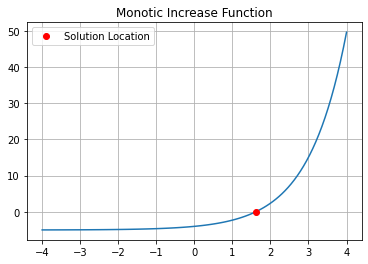

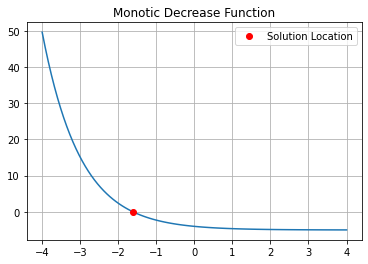

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


x = np.linspace(-4,4, 100)
y = np.exp(x) - 5


plt.title("Monotic Increase Function")

plt.grid(True)

plt.plot(x,y)
plt.plot(np.log(5), 0,'ro',  label="Solution Location")
plt.legend()
plt.show()

x = np.linspace(-4,4, 100)
y = np.exp(-x) - 5


plt.title("Monotic Decrease Function")

plt.grid(True)

plt.plot(x,y)
plt.plot(np.log(1/5), 0,'ro',  label="Solution Location")
plt.legend()
plt.show()




You can find <a href="https://en.wikipedia.org/wiki/Bisection_method#Algorithm">pseudo-code here</a>.


A visualisation of the method illustrates the narrowing in of an ever-smaller bracket:

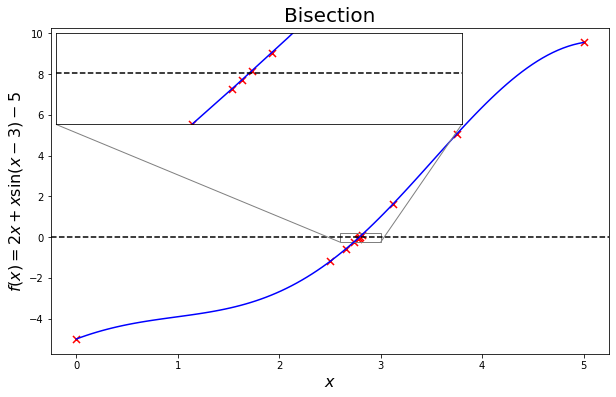

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_bisection(f, x1, x2, ax, tol=1.0e-2, inset=True, ixmin=0.4, ixmax=0.7, iymin=-0.25, iymax=0.2, zoom=5, loc0=4, loc1=2, loc2=1, flabel=''):
    # start by plotting the function over the given bounds (x1, x2)
    x = np.linspace(x1, x2, 100)
    y = f(x)
    ax.plot(x, y, 'b')
    # initialise the first interval
    f1 = f(x1)
    f2 = f(x2)
    x1s = x1
    x2s = x2
    # plot initial interval
    ax.scatter( [x1, x2], [f1, f2], marker='x', color='r', s=50)
    # plot midpoint, and update the appropriate interval limit
    while abs(x1-x2) > tol:
        x3 = 0.5*(x1 + x2)
        f3 = f(x3)
        ax.scatter( [x3], [f3], marker='x', color='r', s=50)
        if f2*f3 < 0.0:
            x1 = x3
            f1 = f3
        else:
            x2 = x3
            f2 = f3

    # add a zero line to the plot to help identify the root
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], color='k', ls='--')
    ax.set_xlim(xlim)
            
    # add a zoomed inset if 'inset=True'
    if inset:
        x1, x2 = x1s, x2s
        ax_ins = zoomed_inset_axes(ax, zoom, loc=loc0)
        # same code/algorithm as above
        x = np.linspace(x1, x2, 100)
        y = f(x)
        ax_ins.plot(x, y, color='b')
        f1 = f(x1)
        f2 = f(x2)
        ax_ins.scatter( [x1,x2], [f1,f2], marker='x', color='r', s=50)
        while abs(x1-x2) > tol:
            x3 = 0.5*(x1 + x2)
            f3 = f(x3)
            ax_ins.scatter( [x3], [f3], marker='x', color='r', s=50)
            if f2*f3 < 0.0:
                x1 = x3
                f1 = f3
            else:
                x2 = x3
                f2 = f3
        ax_ins.plot([ixmin,ixmax],[0.,0.], color='k',ls='--')
        ax_ins.set_xlim(ixmin, ixmax)
        ax_ins.set_ylim(iymin, iymax)
        ax_ins.get_xaxis().set_visible(False)
        ax_ins.get_yaxis().set_visible(False)
        # draw a box of area covered in main image and lines from corners to indicate zoom
        mark_inset(ax, ax_ins, loc1=loc1, loc2=loc2, fc='none', ec='0.5')
        
    xf = (x1 + x2)/2.0
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Bisection', fontsize=20)
    

# Let's see what it looks like for our example.

def f(x):
    return 2*x + x*np.sin(x-3) - 5


fig, ax1 = plt.subplots(figsize=(10,6))
plot_bisection(f, 0., 5., ax1, tol=1.0e-2, inset=True, 
               ixmin=2.6, ixmax=3., iymin=-0.25, iymax=0.2, zoom=10, loc0=2, loc1=3, loc2=4, flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

This algorithm has been <a href="http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.bisect.html#scipy.optimize.bisect">implemented</a> in the `scipy.optimize` module:

In [20]:
def f(x):
    return x - np.exp(-x)

a, b = -1., 1.
print(sop.bisect(f, a, b))

0.5671432904109679


## <span style="color:blue">Exercise 4.4: </span>

For $2x + x \mathrm{sin}(x-3) = 5$, use the subinterval $x \in(a,b)$ you found in Exercise 4.2 and complete the code below to implement a bisection algorithm. Derive the concept from a <a href="https://en.wikipedia.org/wiki/Bisection_method#Algorithm">pseudo-code description</a> and compare the result to `scipy.optimize.bisect`

In [21]:
def bisection(fct, a, b, atol=1.0E-6, nmax=100):
    n = 0
    while n <= nmax:
        
        # complete
    
    raise RuntimeError('no root found within [a,b]')

def f(x):
    return # complete

a, b = # complete

print(bisection(f, a, b))
print(sop.bisect(f, a, b))

IndentationError: expected an indented block (<ipython-input-21-8d6759643c14>, line 7)

# VII.    Newton Method

While the previously introduced bisection method is nice, there are other methods which take less steps to arrive at the solution, and one such method is the Newton Method. To arrive more quickly at the solution, unlike the previous bisection method that only used $f(x)$, i.e. $f(x_1), f(x_2), f(x_3), f(x_4) etc. $ depending on the number of iterative steps, Newton Method also uses derivatives of $f(x)$, such as $f'(x) and f''(x)$ to infer the trend of the function in the vicinity of $x$. This slope, together with the function value $f(x)$, is used to find the intersection of the tangent at $x$ with zero to get an improved iteration method for the root.



$x_{i+1}$ is our updated or new or the closer to the solution value for $x$, and $x_i$ is our previous value for $x$. We understand that our updated value $x_{i+1}$ will not be in the same place as our previous value, and could be some distance away from our previous value. We remind ourselves that the Taylor expansion of function $f(x)$ around a value, say $c$ is written in the form of:

$$ f(x) = f(c) + f'(c)(x-c) + \frac{1}{2!}f''(c)(x-c)^2 + \ldots   $$

Therefore, to find our updated value, we can use the Taylor series expansion around our updated value. We can say that the Taylor series expansion around our updated or new or the closer for solution value for $x$, so $x_{i+1}$ can be expressed as

$$ f(x_{i+1}) = f(x_i) + f'(x_i)(x_{i+1}-x_i) + \frac{1}{2!}f''(x_i)(x_{i+1}-x_i)^2 + \ldots   $$

or 

The formula for Newton Method, also called Newton Raphson Method for some of you who might have covered this in A Levels can be derived from the Taylor series expansion:

\begin{equation}
f(x_{i+1}) = f(x_i) + f'(x_i)(x_{i+1}-x_i) + O(x_{i+1} - x_i)^2
\end{equation}

Since we think that the updated value needs to be closer to the root, we understand that $f(x_{i+1})$ should become ever closer and closer to $0$. Remember, since we have moved everything to one side, finding the location where $f(x) =0$ is the same as finding the solution to our equation.  Let $f(x_{i+1}) = 0$ to find

\begin{equation}
0 = f(x_i) + f'(x_i)(x_{i+1}-x_i) + O(x_{i+1} - x_i)^2
\end{equation}

assuming $x_{i+1}$ close to $x_{i}$ we drop the higher order terms, since they are very small (this might come to bite us later, but it should work fine for most cases) and rearrange the equation slightly to find that

\begin{equation}
x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}
\end{equation}

which is the **Newton-Raphson formula**.

A pseudo pseudo-code for the algorithm looks like this:

```
guess x[0]
do
    x[i] = x[i-1] - f(x[i-1])/dfdx(x[i-1])
while abs(x[i] - x[i-1]) > tolerance
```

The expression of the associated error indicates quadratic convergence:

\begin{equation}
\epsilon_{i+1} = -\frac{f''(x)}{2f'(x)} \epsilon_{i}^2
\end{equation}

Illustrated, for $f(x) = x - \mathrm{e}^{-x}$, this approximation looks like the following.

Note that the green dashed lines extend off from the current iteration in the direction given by the slope of the blue line:

While I would definitely like to see you going through the code and understanding its implementation to reinforce and help you with reading code in the future, I would write out here the iterative process of the code to help you a bit in case you get confused at the code from below. 

Let's try to take an inital guess to solve this problem, say $x_0 = 1$

To use the Newton Raphson Method, I need to find both $f'(x)$

$$f(x) = x-e^{-x}$$

$$f'(x) = 1 + e^{-x} $$

To find our improved value for $x$, so $x_1$, we use the formula from above and we have

$$x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}$$

$$x_{1} = x_0 - \frac{f(x_0)}{f'(x_0)}$$

$$x_{1} = 1 - \frac{f(0)}{f'(0)}$$

$$x_{1} = 1 - \frac{f(0)}{f'(0)}$$

$$x_{1} = 1 - \frac{1-e^{-1}}{1 + e^{-1}}$$

$$x_{1} = 1 - \frac{1-e^{-1}}{1 + e^{-1}}$$

$$x_{1} = 0.5379$$

Now, you have $x_{1} = 0.5379$ which is closer to the actual solution. Let's do another iteration and find $x_2$, and even more improved value for $x$ compared to $x_1$

To find our even more improved value for $x$, so $x_2$, we use the formula from above and we have

$$x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}$$

$$x_{2} = x_1 - \frac{f(x_1)}{f'(x_1)}$$

$$x_{2} = 0.5379 - \frac{f(0.5379)}{f'(0.5379)}$$

$$x_{2} = 0.5379 - \frac{f(0.5379)}{f'(0.5379)}$$

$$x_{2} = 0.5379 - \frac{0.5379-e^{-0.5379}}{1 + e^{-0.5379}}$$

$$x_{2} = 0.5379 - \frac{0.5379-e^{-0.5379}}{1 + e^{-0.5379}}$$

$$x_{2} = 0.5670$$

And we keep on doing this, and so on and so forth!

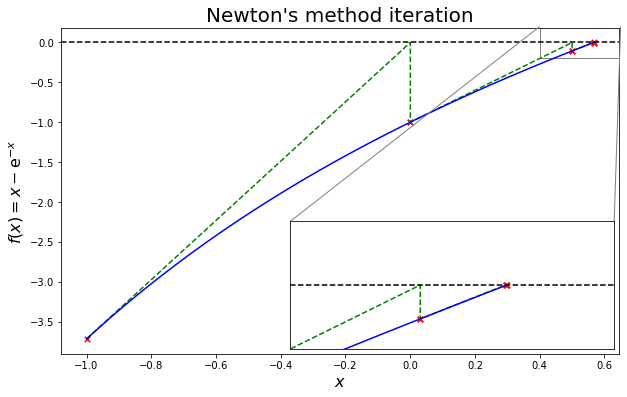

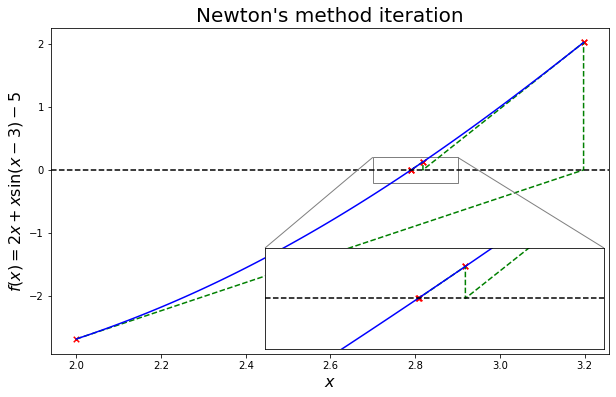

In [22]:
def plot_newton(f, dx, x_0, atol, ax, inset=True, ixmin=3.0, ixmax=3.2, 
                iymin=-0.1, iymax=0.1, zoom=8, loc0=1, loc1=3, loc2=2, maxiter=100, resfct=100, flabel=''):
    x_n = [x_0]
    y_n = [f(x_0)]    
    
    # Newton iteration
    i = 0
    # iterate until we hit break either as we hit tolerance or maximum number iterations
    while 1:
        # approximate gradient - computed using a dx value - note comments below on quasi-newton
        dfdx = (f(x_n[-1]+dx) - f(x_n[-1])) / dx
        # Newton-Raphson update
        x_zero = x_n[-1] - ( f(x_n[-1]) / dfdx )
        x_n.append(x_zero)        
        y_n.append(0.)
        if abs(x_n[-1]-x_n[-2]) < atol:
            break
        x_n.append(x_zero)
        y_n.append(f(x_zero))
        i = i+1
        if i >= maxiter:
            break
        
    # the iteration results
    ax.scatter(x_n, f(np.array(x_n)), marker='x', color='red', s=30)
    
    # the convergence pattern
    ax.plot(x_n, y_n, color='green', ls='--')
        
    # the function
    x = np.linspace( np.min(x_n), np.max(x_n), resfct)
    ax.plot(x, f(x), 'b')
    
    # zero line
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)

    # zoomed inset
    if inset:
        axins = zoomed_inset_axes(ax, zoom, loc=loc0)
        axins.scatter(x_n, f(np.array(x_n)), marker='x', color='red', s=30)
        axins.plot(x_n, y_n, color='green', ls='--')
        axins.plot(x, f(x), 'b')
        axins.plot([ixmin,ixmax],[0.,0.], 'k--')
        axins.set_xlim(ixmin, ixmax)
        axins.set_ylim(iymin, iymax)
        axins.get_xaxis().set_visible(False)
        axins.get_yaxis().set_visible(False)
        mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.5")
    
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title("Newton's method iteration", fontsize=20)


# case 1
def f(x):
    return x - np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -1.
plot_newton(f, 1.e-3, x0, 1.e-2, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=0.4, ixmax=0.65, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

# case 2
def f(x):
    return 2*x + x*np.sin(x-3) - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 2.0

plot_newton(f, 1.e-3, x0, 1.e-2, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=2.7, ixmax=2.9, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

This algorithm has been <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html">implemented</a> in the `scipy.optimize` module:

In [23]:
def f(x):
    return x - np.exp(-x)

def dfdx(x):
    return 1 + np.exp(-x)

x0 = -1. # initial guess
print(sop.newton(f, x0, dfdx))

0.567143290409784


## <span style="color:blue">Exercise 4.5: </span>

For $2x + x \mathrm{sin}(x-3) = 5$, use $a$ from the subinterval $x \in(a,b)$ you found in Exercise 4.2 as initial guess $x_0$ and complete the code below to implement a Newton algorithm. Compare the result to [scipy.optimize.newton](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html)

In [24]:
def newton(f, x0, dfdx, atol=1.0e-6):
    """ Function to implement the Newton-Raphson method
    
    f is the function we are trying to find a root of
    
    and dfdx is another function which return the derivative of f
    """
    x = [x0]
    fevals = 0
    while True:
        x.append( ...............
        fevals +=  ...................
        if abs(x[-1]-x[-2]) < atol:
            print('Newton (analytical derivative) used', fevals, 'function evaluations')
            return x[-1]


def f(x):
    return # complete ...

def dfdx(x):
    return # complete ...

x0 = 0. # initial guess somwhere in interval
print(newton(f, x0, dfdx))
print(sop.newton(f, x0, dfdx))

SyntaxError: invalid syntax (<ipython-input-24-e559600f71d9>, line 11)

## VIII.    (Quasi-) Newton with approximate derivative 

Basically, this is still the Newton Method. Just this time instead of using the exact $f'(x)$, you would use an approximate for $f'(x)$ in the form of 

$$ f'(x) \approx \frac{f(x+\Delta x) - f(x)}{\Delta x}. $$

either because the exact derivatives of some function may be difficult to compute, non existent, or your dexterity stat is too low, and you are unable to type the full exact derivative of the function without spelling mistakes. 

The implementation of the Newton method above assumes that the derivative $f^\prime(x)$ is readily available. 

[Although note that this was not the case in the plotting function `plot_newton` where we computed an approximation to it].

For many problems, however, the derivative is not easy to express analytically or we just don't want to bother working it out and writing a function to implement it. 

In these cases $f^\prime(x)$ can be replaced by a difference approximation such as

$$ f'(x) \approx \frac{f(x+\Delta x) - f(x)}{\Delta x}. $$

Use of an approximate derivative renders the corresponding root finding algorithm a co-called *quasi-Newton* method.


Note that since we only have an approximate derivative we cannot in general expect this method to converge as well as Newton when we supply it with an exact derivative. This manifests in a reduction from perfect quadratic convergence - but still generally closer to quadratic that linear!

## <span style="color:blue">Exercise 4.6: </span>

Extend the Newton algorithm to compute $f^\prime(x)$ using a finite difference approximation. Compare the result to `scipy.optimize.newton`

In [25]:
def quasi_newton(f, x0, dx=1.0E-7, atol=1.0E-6):
    """ Function to implement quasi-newton
    
    f is the function we are trying to find a root of
    """
    x = [x0]
    while True:
        ......
        ......
        if abs(x[-1]-x[-2]) < atol:
            return x[-1]

    
def f(x):
    return # complete ...

x0 = 0.
print(quasi_newton(f, x0))
print(sop.newton(f, x0))

SyntaxError: invalid syntax (<ipython-input-25-a7de430363a4>, line 8)

# IX.   Secant Method

Now that you have gone through the Bisection and the Newton Method, you should have a good grasp at what these methods for finding the numerical solution entail, and also how to program these methods in Python so well, this is a new method, go ahead and program it! ;)

The Secant method replaces the local derivative in the Newton method by a difference approximation based on two consecutive $x_n$. It follows that

\begin{equation}
f'(x_n) \approx \frac{f(x_n) - f(x_{n-1})}{x_n - x_{n-1}}
\end{equation}

which leads to the secant method

\begin{equation}
x_{n+1} = x_n - f(x_n) \left ( \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})} \right )
\end{equation}

The algorithm can be visualized as follows:

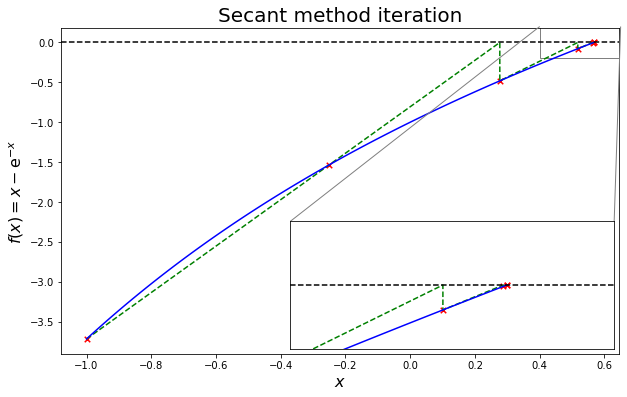

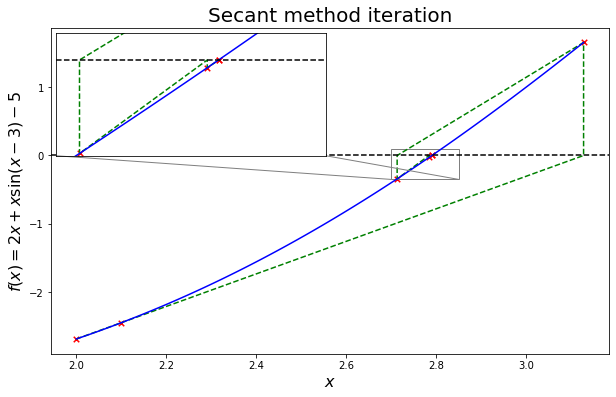

In [26]:
def plot_secant(f, x_0, x_1, atol, ax, max_labels0=1, inset=True, ixmin=3.0, ixmax=3.2, 
                iymin=-0.1, iymax=0.1, zoom=8, loc0=1, loc1=3, loc2=2, maxiter=100, resfct=100, flabel=''):
    # variables to store to convergence pattern, initialise with two initial guess values
    x_n = [x_0, x_1] 
    y_n = [f(x_0), f(x_1)]    
    x_its = [x_0, x_1]
    # iterate secant method and store iteration convergence pattern
    i = 0
    # iterate until we hit break either as we hit tolerance or maximum number iterations
    while 1:     
        # Secant update
        x_zero = x_its[-1] - f(x_its[-1])*( (x_its[-1] - x_its[-2]) / (f(x_its[-1]) - f(x_its[-2])) )
        x_n.append(x_zero)        
        y_n.append(0.)
        x_its.append(x_zero)
        if abs( x_n[-1] - x_n[-2] ) < atol:
            break
        x_n.append(x_zero)
        y_n.append(f(x_zero))
        i = i+1
        if i >= maxiter:
            break

    # the iteration results
    ax.scatter(x_its, f(np.array(x_its)), marker='x', color='red', s=30)
    
    # the convergence pattern
    ax.plot(x_n, y_n, color='green', ls='--')
     
    # the function
    x = np.linspace( np.min(x_n), np.max(x_n), resfct)
    ax.plot(x, f(x), 'b')

    # zero line
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [0., 0.], 'k--')
    ax.set_xlim(xlim)

    # zoomed inset
    if inset:
        axins = zoomed_inset_axes(ax, zoom, loc=loc0)
        axins.scatter(x_its, f(np.array(x_its)), marker='x', color='red', s=30)
        axins.plot(x_n, y_n, color='green', ls='--')
        axins.plot(x, f(x), 'b')
        axins.plot([ixmin,ixmax],[0.,0.], 'k--')
        axins.set_xlim(ixmin, ixmax)
        axins.set_ylim(iymin, iymax)
        axins.get_xaxis().set_visible(False)
        axins.get_yaxis().set_visible(False)
        mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.5")        
        
    ax.set_xlabel('$x$', fontsize=16)
    if not flabel:
        fl = '$f(x)$'
    else:
        fl = flabel
    ax.set_ylabel(fl, fontsize=16)
    ax.set_title('Secant method iteration', fontsize=20)


# case 1
def f(x):
    return x - np.exp(-x)


x0 = -1.
x1 = x0+0.75
fig, ax1 = plt.subplots(figsize=(10,6))
plot_secant(f, x0, x1, 1E-3, ax1, loc0=4, loc1=2, loc2=1,
                                            zoom=4, ixmin=0.4, ixmax=0.65, iymin=-0.2, iymax=0.2,
                                            flabel=r'$f(x) = x - \mathrm{e}^{-x}$')

# case 2
def f(x):
    return 2*x + x*np.sin(x-3) - 5


fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 2.
x1 = x0+0.1
plot_secant(f, x0, x1, 1E-3, ax1, loc0=2, loc1=3, loc2=4, inset=True,
                                            zoom=4, ixmin=2.7, ixmax=2.85, iymin=-0.35, iymax=0.1,
                                            flabel=r'$f(x) = 2x + x\sin(x-3) - 5$')

## <span style="color:blue">Exercise 4.7:</span> 

For $2x + x \mathrm{sin}(x-3) = 5$, use $a$ from the subinterval $x \in(a,b)$ you found in Exercise 4.2 to find $x_0 = a$ and $x_1 = a+0.1$ and complete the code below to implement a Secant algorithm. Compare the result to `scipy.optimize.newton`

In [27]:
def secant(f, x0, x1, atol=1.0E-6):
    """ Function to implement the secant method
    
    x0 and x1 are the two required guesses
    
    f is the function we are trying to find a root of
    """
    x = [x0, x1]
    while True:
        dfdx = .....
        x.append(.......
        if abs(x[-1]-x[-2]) < atol:
            return x[-1]

def f(x):
    return 2*x + x*np.sin(x-3) - 5

x0 = 0.
x1 = x0+0.1
print(secant(f, x0, x1))
print(sop.newton(f, x0))

SyntaxError: invalid syntax (<ipython-input-27-cbdc294213f0>, line 10)

# X.  Potential convergence Issues

It's important to understand the ways some of the methods we've introduced can go wrong, and again to emphasise the value of a good starting guess.

Let's start by illustrating the basic concept of Newton root-finding methods for a well-behaved function

$$ f(x) := x^4 - 5. $$

Let's first reillustrate the basic concept of Newton root-finding methods for a well behaved function

\begin{equation}
f(x) = x^4 - 5
\end{equation}

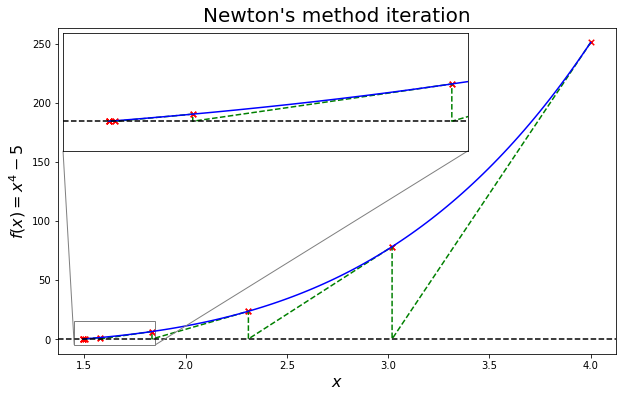

In [28]:
def f(x):
    return x**4 - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 4.0
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, loc0=2, loc1=3, loc2=4, zoom=5,
                                            ixmin=1.45, ixmax=1.85, iymin=-5, iymax=15, flabel=r'$f(x) = x^4 - 5$')

We've said several times now that the convergence of many algorithms often depends on the initial values provided to them. 

Complex equations, or systems thereof, provide plenty of situations that prevent convergence all together, lead to slow convergence, or cause convergence to an undesired root (e.g. one that is far from, and not the closest to, the initial guess). 

Their solution strongly depends on having a *good* initial guess. 

For example,

$$ f(x) = x\, \sin(\pi x) - e^{-x}, $$

provides for ample pitfalls, in particular for gradient-based methods (e.g. Newton and Secant).

We will illustrate these convergence issues below. 


They mostly fall into one of three categories:


1. Multiple roots in the vicinity - the algorithm converges to one of them, but this "one" could change with only slight changes to the initial guess.


2. Nearly singular/numerical overflow - the local gradient at guess $x^{(k)}$ is near zero, so that $x^{(k+1)}$, the intersection of the local gradient approximation with the $x$ axis is beyond the representable range. Even if we don't get overflow, we can still jump to a location a long distance away from our initial guess and end up converging to the wrong root.


3. Oscillations - the algorithm bounces back and forth between (near) identical $x^{(k)}$.

## Multiple roots

For many functions multiple roots exist, and the algorithm depends on and can be sensitive to the initial guess.

Let's see an example where we choose two initial guesses (0.0 and 0.1) and visualise how this relatively small difference leads to convergence to different roots.

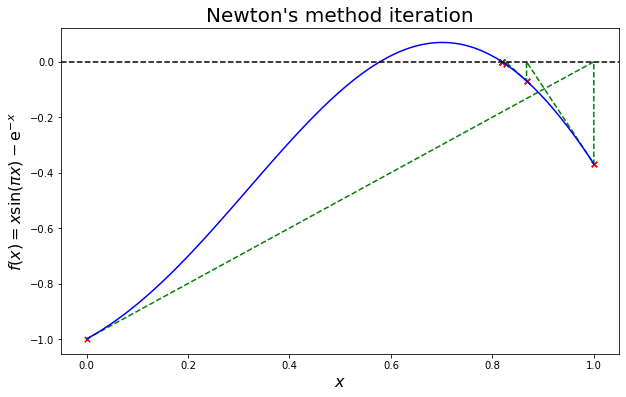

In [29]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 0.0
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

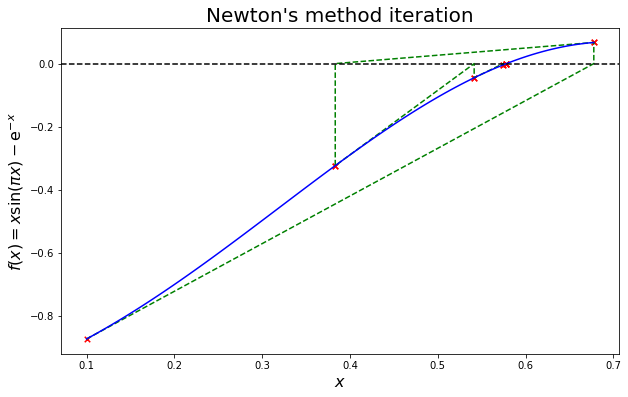

In [30]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
# a small perturbation to the initial guess
x0 = 0.1
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

We see from the first plot that this problem has roots at just under 0.6 and just over 0.8.  The initial guess of 0 leads to convergence of the Newton iteration to the larger root, whereas a slightly higher initial guess of 0.1 leads to the smaller root!

We confirm this behaviour is not a product of an issue with our implementation, and print the two actual root values, using calls to the SciPy function below.

In [31]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

x0 = 0.0
print(sop.newton(f, x0))
x0 = 0.1
print(sop.newton(f, x0))

0.8191177934425945
0.578262577864515


## Nearly singular/numerical overflow

In this case the gradient $\,f'(x^{(k)})\,$ is close to zero, so that the new iteration value, $x^{(k+1)}$, is orders of magnitude offset, perhaps too big even to be representable on our finite computer ([*overflow*](https://en.wikipedia.org/wiki/Integer_overflow)).

We see this with the following example.

Remember how the formula for the Newton method was

\begin{equation}
x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}
\end{equation}

Thus remember how for every iteration, you had to divide by $f'(x_i)$?

If your $f(x_i)$ is very close to $0$, then since $f(x_i)$ is very small, when you divide the numerator by this, this will most certainly result in a very small number. 

Remember how a computer can only deal with limited number of decimals places, well the same goes the other way too, so a computer can only deal with a finite large number, and not very well with infinity. While you could program it out and Python does provide support for infinity, inifinity is still usually something that computer neither like nor understand very well. 

This results in numerical overflow, meaning that the number is too large for your computer to handle and the computer just gets really confused ... 

A method to deal with this problem is to use the Quasi Newton Method or the Secant Method, or even the Bisection method instead. However, note that these methods also have situations where they fail, so it is important to note the capabilities of each method. There may be nothing wrong with your code, it may simply be the method at fault. 

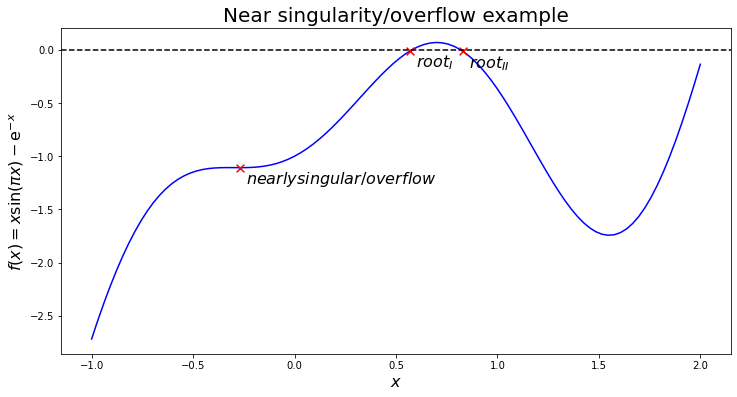

In [32]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

x = np.linspace(-1, 2, 100)
y = f(x)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(x, y, color='b', zorder=0)
xs = [0.57, 0.83, -0.27]
texts = ['$root_I$', '$root_{II}$', '$nearly singular/overflow$']
for i in range(len(xs)):
    ax1.scatter([xs[i]], [f(xs[i])], marker='x', color='r', s=60)
    ax1.text(xs[i]+0.03, f(xs[i])-0.15, texts[i], fontsize=16)
xlim = ax1.get_xlim()
ax1.plot([xlim[0], xlim[1]], [0., 0.], 'k--', label='$y(x)=0$')
ax1.set_xlim(xlim)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$', fontsize=16)
ax1.set_title('Near singularity/overflow example', fontsize=20);

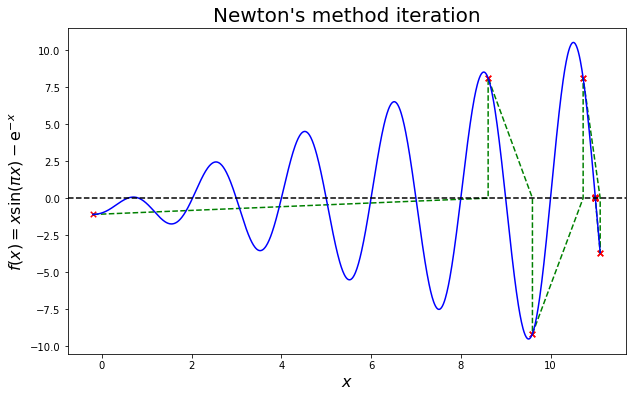

In [33]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.2
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

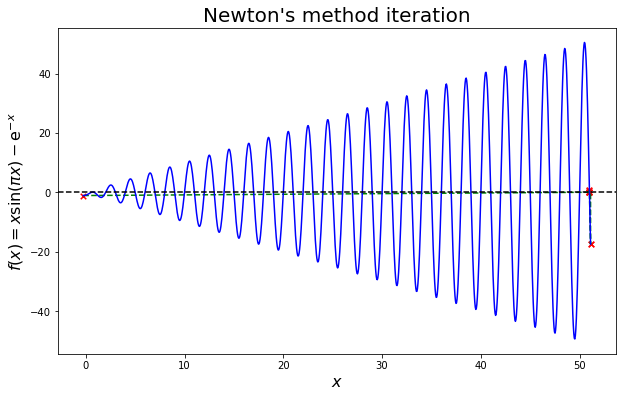

In [34]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.25
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

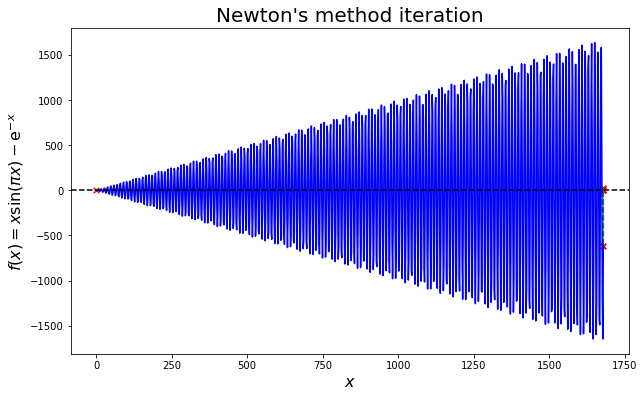

In [35]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.268
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

<ipython-input-36-5921017847f3>:2: RuntimeWarning: overflow encountered in exp
  return x*np.sin(np.pi*x)-np.exp(-x)
<ipython-input-22-2a95dd3ffbb6>:11: RuntimeWarning: invalid value encountered in double_scalars
  dfdx = (f(x_n[-1]+dx) - f(x_n[-1])) / dx


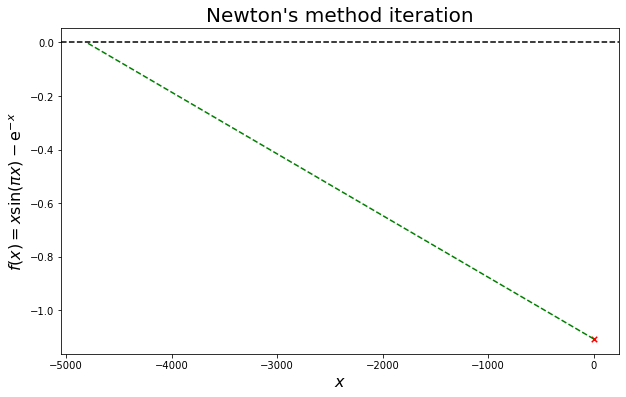

In [36]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -0.269
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=100, resfct=1000,
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

In [37]:
def f(x):
    return x*np.sin(np.pi*x)-np.exp(-x)

# do we converge for a slightly larger initial guess?
x0 = -0.2684
print(sop.newton(f, x0))

# but see what happens if you make this x0 very slightly smaller!
x0 = -0.2685
print(sop.newton(f, x0))



# we converge to the first root in the image above if we start with an appropriate value
x0 = 0.5
print(sop.newton(f, x0))


# and similarly the second root shown in the above plot
x0 = 1.0
print(sop.newton(f, x0))

4.999570827870424
24017.65375762087
0.578262577864515
0.8191177934426115


<ipython-input-37-920b2c53e186>:2: RuntimeWarning: overflow encountered in exp
  return x*np.sin(np.pi*x)-np.exp(-x)


## Oscillation

In this scenario the iterations are trapped in a region with gradients of approximately equal magnitude but opposite directions.

Basically, our numerial solution methods here use an iterative approach to get closer and closer to the solution and narrow down the location that the solution is in. However, this is done with the assumption that within our initial guess as to the range where our solution is, there is actually a solution. If there is no solution, and you apply Newton method, then the method will just try to search for something that does not exist and get confused. 

Oscillation problems could also happen when the iterations are trapped in a region where gradients to either side have equal magnitude but oppisite direction, sorta something like symmetry. 

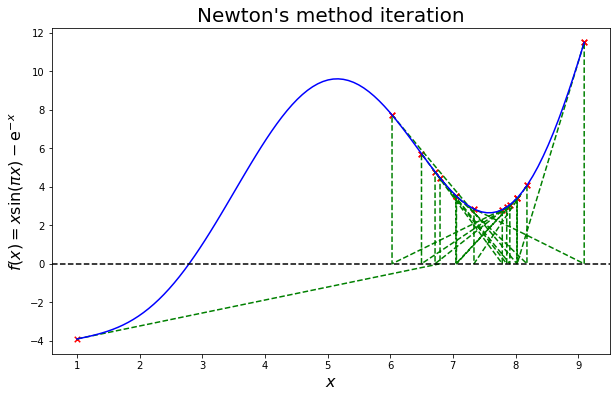

In [38]:
def f(x):
    return 2*x + x*np.sin(x-3) - 5

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = 1.
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=14, 
                                            flabel='$f(x)= x \mathrm{sin}(\pi x) - \mathrm{e}^{-x}$')

What happens if you increase the number of iterations?

Another similar example:

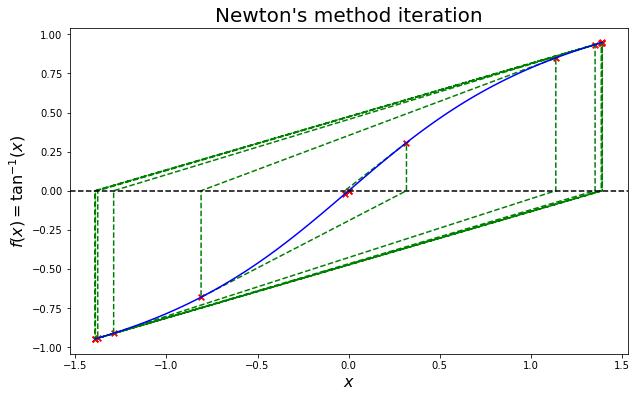

In [47]:
def f(x):
    return np.arctan(x)

fig, ax1 = plt.subplots(figsize=(10,6))
x0 = -1.3917
plot_newton(f, 1.e-8, x0, 1.e-7, ax1, inset=False, maxiter=10000, 
                                            flabel='$f(x)= \mathrm{tan}^{-1}(x)$')